Let's do what we did last time, but with bipolar vectors to see which performs better.

In [164]:
using Random
using LinearAlgebra
"""
Construct a binary vector. By default 10000 elements long.
"""
hdv(N::Int=10000) = rand((-1,1), 1, N)


"""
Bundles bipolar hyperdimensional vectors.
"""
add(vectors::Vector{Int}...) = reduce(.+, vectors) .|> sign


"""
Binds binpolar hyperdimensional vectors.
"""
multiply(vectors::Vector{Int}...) = reduce(.*, vectors)


"""
Permutes a bipolar hyperdimensional vector by an adjustable circular shift.
"""
perm(vector::Vector, k::Int=1) = circshift(vector, (0, k))


"""
Calculates the cosine similarity between two bipolar vectors.
"""
cosine(x::Vector{Int}, y::Vector{Int}) = dot(x, y) / (norm(x) * norm(y))

cosine

Here we see the dataset.

In [165]:
using DataFrames, CSV
data = CSV.read("zoo.csv", DataFrame)

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed
,String15,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,aardvark,1,0,0,1,0,0,1,1
2,antelope,1,0,0,1,0,0,0,1
3,bass,0,0,1,0,0,1,1,1
4,bear,1,0,0,1,0,0,1,1
5,boar,1,0,0,1,0,0,1,1
6,buffalo,1,0,0,1,0,0,0,1
7,calf,1,0,0,1,0,0,0,1
8,carp,0,0,1,0,0,1,0,1
9,catfish,0,0,1,0,0,1,1,1


Let us extract the class type of every animal. The class of an animal can be mammal, bird, reptile, fish, amphibian, bug or invertebrate.

In [166]:
classls = data.class_type

101-element Vector{Int64}:
 1
 1
 4
 1
 1
 1
 1
 4
 4
 1
 ⋮
 4
 1
 1
 2
 1
 6
 1
 7
 2

Here we collect the index of every animal in the dataset and store them seperated by class type to easily retreive them later.

In [167]:
mammal_idx = [i for i in 1:101 if data.class_type[i] == 1]
bird_idx = [i for i in 1:101 if data.class_type[i] == 2]
reptile_idx = [i for i in 1:101 if data.class_type[i] == 3]
fish_idx = [i for i in 1:101 if data.class_type[i] == 4]
amphibian_idx = [i for i in 1:101 if data.class_type[i] == 5]
bug_idx = [i for i in 1:101 if data.class_type[i] == 6]
invertebrate_idx = [i for i in 1:101 if data.class_type[i] == 7]

indices = [mammal_idx, bird_idx, reptile_idx, fish_idx, amphibian_idx, bug_idx, invertebrate_idx]

7-element Vector{Vector{Int64}}:
 [1, 2, 4, 5, 6, 7, 10, 11, 18, 20  …  69, 70, 71, 75, 76, 85, 94, 95, 97, 99]
 [12, 17, 21, 22, 24, 34, 38, 42, 44, 57, 58, 59, 60, 72, 79, 80, 84, 88, 96, 101]
 [63, 77, 81, 91, 92]
 [3, 8, 9, 13, 19, 35, 39, 61, 62, 74, 83, 87, 93]
 [26, 27, 53, 90]
 [25, 31, 40, 41, 43, 52, 89, 98]
 [14, 15, 16, 47, 54, 73, 78, 82, 86, 100]

Because every feature is binary except for the amount of legs, we will rearrange the dataset to be easily manipulated later on.

In [168]:
legs0 = [i == 0 ? 1 : 0 for i in data.legs]
legs2 = [i == 2 ? 1 : 0 for i in data.legs]
legs4 = [i == 4 ? 1 : 0 for i in data.legs]
legs5 = [i == 5 ? 1 : 0 for i in data.legs]
legs6 = [i == 6 ? 1 : 0 for i in data.legs]
legs8 = [i == 8 ? 1 : 0 for i in data.legs]

select!(data, Not(:class_type))
select!(data, Not(:legs))

data[!, :legs0] = legs0
data[!, :legs2] = legs2
data[!, :legs4] = legs4
data[!, :legs5] = legs5
data[!, :legs6] = legs6
data[!, :legs8] = legs8

101-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

Representing a range of numbers by hyperdimensional vectors is also simple. We construct a random hyperdimensional vector representing the lower bound of the interval. Next, we replace a fraction of the vector by random bits which must represent the number in the next step. This assures us in this case that having 2 legs is more similar to having 4 legs than 8 legs.

We also create random hyperdimensional vectors for every other feature and throw them together in a list.

In [169]:
"""
Creates a list of bipolar hyperdimensional vectors representing an interval of numbers by constructing a random HDV representing the lower bound of the interval and replacing a fraction of the vector with random bits.
"""
function range_hdvs(steps)
	k = length(steps) - 1
	V = [hdv() for i in 1:k+1]
	for i in 2:k+1
		for j in 1:10000
			V[i][j] = rand((-1, 1))
		end
	end
	return V
end

legs_steps = 0:1:8
legs_hdvs = range_hdvs(legs_steps)

feature_hdv=[hdv() for i in 1:15]
append!(feature_hdv, [legs_hdvs[1], legs_hdvs[3], legs_hdvs[5], legs_hdvs[6], legs_hdvs[7], legs_hdvs[9]])

21-element Vector{Matrix{Int64}}:
 [1 1 … -1 1]
 [1 1 … 1 -1]
 [1 1 … 1 1]
 [1 1 … 1 1]
 [-1 -1 … -1 -1]
 [1 1 … 1 -1]
 [1 1 … 1 1]
 [-1 1 … -1 1]
 [1 -1 … -1 1]
 [-1 -1 … 1 -1]
 ⋮
 [-1 1 … 1 1]
 [1 -1 … 1 -1]
 [1 -1 … 1 1]
 [1 1 … 1 -1]
 [-1 -1 … -1 1]
 [-1 -1 … -1 1]
 [1 -1 … -1 1]
 [1 -1 … -1 -1]
 [1 -1 … -1 1]

To demonstrate the binding of HDVs, we can encode the types of feature into our feature set. For example, the 'milk, and 'egg' feature gives us information about the growth of the animal, so we will bind these features to an other vector representing the growth feature to obtain a more expanded model. This is also done for the skin protection features and for all the features considering the limbs.

In [170]:
growth_hdv = hdv()
skin_protection = hdv()
limbs = hdv()

for i in 1:2
    feature_hdv = replace!(feature_hdv, feature_hdv[i] => multiply(feature_hdv[i], skin_protection))
end

for i in 3:4
    feature_hdv = replace!(feature_hdv, feature_hdv[i] => multiply(feature_hdv[i], growth_hdv))
end

for i in 13;16:21
    feature_hdv = replace!(feature_hdv, feature_hdv[i] => multiply(feature_hdv[i], limbs))
end

Now we can bundle every feature for an animal to obtain a hyperdimensional vectors representing the animal.

In [171]:
y = []
for i in 1:101
    v = []
    for j in 2:22
        if data[!, j][i] == 1
            push!(v, feature_hdv[j-1])
        end
    end
    x = add(v...)
    push!(y, x)
end

data[!, :species_hdv] = y


101-element Vector{Any}:
 [0 -1 … 0 1]
 [0 -1 … -1 1]
 [1 1 … 0 1]
 [0 -1 … 0 1]
 [1 -1 … -1 1]
 [0 -1 … -1 1]
 [1 -1 … -1 1]
 [1 1 … 0 0]
 [1 1 … 0 1]
 [-1 -1 … -1 1]
 ⋮
 [1 1 … 1 1]
 [-1 -1 … -1 1]
 [-1 -1 … -1 1]
 [1 -1 … -1 1]
 [0 -1 … -1 1]
 [-1 -1 … 0 -1]
 [1 -1 … -1 1]
 [1 -1 … 1 -1]
 [-1 -1 … -1 -1]

Let's bundle all animals of a class into a HDV representing the class.

In [172]:
function grouper(group::Int)
    v = []
    for i in 1:length(indices[group])
        push!(v, data.species_hdv[indices[group][i]])
    end
    x = add(v...)
    return x
end

mammal_hdv = grouper(1)
bird_hdv = grouper(2)
reptile_hdv = grouper(3)
fish_hdv = grouper(4)
amphibian_hdv = grouper(5)
bug_hdv = grouper(6)
invertebrate_hdv = grouper(7)

1×10000 Matrix{Int64}:
 1  0  1  1  1  -1  -1  0  -1  1  -1  …  -1  1  1  1  0  1  1  -1  0  1  -1

Here we construct one large matrix containing the HDV of every class. This will be needed later for an PCA analysis.

In [173]:
list_group_hdvs = [mammal_hdv; bird_hdv; reptile_hdv; fish_hdv; amphibian_hdv; bug_hdv; invertebrate_hdv]

7×10000 Matrix{Int64}:
  1  -1  -1  1  -1  -1   1  1  -1   1  …  -1   1  -1  -1  -1  -1  -1  -1   1
  1  -1   1  1   1   1  -1  1  -1  -1      1   1   1   1  -1  -1  -1  -1  -1
  1   1  -1  1  -1   1  -1  1  -1  -1      1   1  -1   1  -1  -1   1  -1   1
  1   1  -1  1  -1   1  -1  0  -1   1      1   1  -1   1  -1  -1  -1   1   1
  1  -1  -1  1  -1  -1   1  1  -1  -1      1   1  -1   1  -1  -1   1  -1   1
 -1  -1   1  1  -1  -1  -1  1  -1  -1  …   0  -1   1   1  -1  -1   1  -1  -1
  1   0   1  1   1  -1  -1  0  -1   1      1   1   0   1   1  -1   0   1  -1

Let's compare the HDV of the flamingo to the HDVs of every animal class to see which class it resembles the most by calculating the cosine between the HDV of flamingo and the class in question.

In [174]:
println("mammal ",string(cosine(data.species_hdv[24], mammal_hdv)))
println("bird ",string(cosine(data.species_hdv[24], bird_hdv)))
println("reptile ",string(cosine(data.species_hdv[24], reptile_hdv)))
println("amphibian ",string(cosine(data.species_hdv[24], amphibian_hdv)))
println("bug ",string(cosine(data.species_hdv[24], bug_hdv)))
println("fish ",string(cosine(data.species_hdv[24], fish_hdv)))
println("invertebrate ",string(cosine(data.species_hdv[24], invertebrate_hdv)))

mammal 0.36708845005606533
bird 0.859737235591479
reptile 0.4348949715807321
amphibian 0.312536065859942
bug 0.37385132754379186
fish 0.3492561834131244
invertebrate 0.24633777490304906


Like expected, the flamingo shows most similarity to the bird group! Let's try the animal vampire since I'm not sure what's ment by this...

In [175]:
println("mammal ",string(cosine(data.species_hdv[94], mammal_hdv)))
println("bird ",string(cosine(data.species_hdv[94], bird_hdv)))
println("reptile ",string(cosine(data.species_hdv[94], reptile_hdv)))
println("amphibian ",string(cosine(data.species_hdv[94], amphibian_hdv)))
println("bug ",string(cosine(data.species_hdv[94], bug_hdv)))
println("fish ",string(cosine(data.species_hdv[94], fish_hdv)))
println("invertebrate ",string(cosine(data.species_hdv[94], invertebrate_hdv)))

mammal 0.6011050440419825
bird 0.49822530699693846
reptile 0.42330932094842244
amphibian 0.3076837535620038
bug 0.3256552225637974
fish 0.2865285967781827
invertebrate 0.048552955247673134


Let's try to determine the class of an animal not present in the dataset, such as the axolotl. First we have to define the features of the axolotl.

In [176]:
axolotl_features = [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]

21-element Vector{Int64}:
 0
 0
 1
 0
 0
 1
 0
 1
 1
 1
 ⋮
 1
 0
 0
 0
 0
 1
 0
 0
 0

Let's construct the total HDV representing the axolotl

In [177]:
v = []
    for j in 1:16
        if axolotl_features[j] == 1
            push!(v, feature_hdv[j])
        end
    end
    axolotl_hdv = add(v...)

1×10000 Matrix{Int64}:
 1  0  0  1  0  -1  0  1  -1  -1  -1  0  …  -1  1  1  0  -1  -1  -1  1  -1  0

Let's find out what kind of aninal an axolotl is...

In [178]:
println("mammal ",string(cosine(axolotl_hdv, mammal_hdv)))
println("bird ",string(cosine(axolotl_hdv, bird_hdv)))
println("reptile ",string(cosine(axolotl_hdv, reptile_hdv)))
println("amphibian ",string(cosine(axolotl_hdv, amphibian_hdv)))
println("bug ",string(cosine(axolotl_hdv, bug_hdv)))
println("fish ",string(cosine(axolotl_hdv, fish_hdv)))
println("invertebrate ",string(cosine(axolotl_hdv, invertebrate_hdv)))

mammal 0.4423565866065437
bird 0.5368932772033634
reptile 0.6816359819369116
amphibian 0.6456107122216129
bug 0.31191701404012223
fish 0.6128947681177662
invertebrate 0.3828585856196796


It seems to have a lot of similarities to fish, reptiles and amphibians due to it's unusual features but we're pretty close to amphibian considering the simplicity of this classifier!

Now we will show how the HDVs of every class are seperated via an PCA analysis.

In [179]:
using MultivariateStats

M = fit(PCA, list_group_hdvs ; maxoutdim=2)
proj = projection(M)
M

PCA(indim = 7, outdim = 2, principalratio = 0.6083737431912971)

Pattern matrix (unstandardized loadings):
──────────────────────
        PC1        PC2
──────────────────────
1  0.637246  -0.360608
2  0.649156   0.221155
3  0.820407  -0.19998
4  0.670121  -0.279428
5  0.778975  -0.114994
6  0.482411   0.726148
7  0.651821   0.271276
──────────────────────

Importance of components:
─────────────────────────────────────────────
                                PC1       PC2
─────────────────────────────────────────────
SS Loadings (Eigenvalues)  3.21401   0.911125
Variance explained         0.474001  0.134373
Cumulative variance        0.474001  0.608374
Proportion explained       0.779128  0.220872
Cumulative proportion      0.779128  1.0
─────────────────────────────────────────────

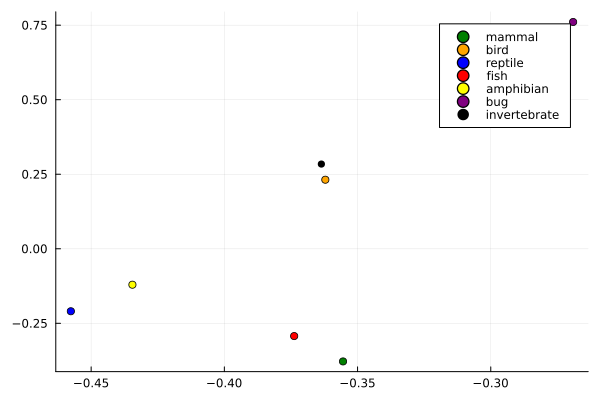

In [180]:
using Plots

function plotter()
    colors = [:green, :orange, :blue, :red, :yellow, :purple, :black]
    labels = ["mammal", "bird", "reptile", "fish", "amphibian", "bug", "invertebrate"]
    fig = Plots.plot()

    for i in 1:7
        scatter!(fig, (proj[i, 1], proj[i, 2]), label=labels[i], mc = colors[i])
    end
    return fig
end

plotter()

This plots looks exactly the same to equivalent one made out of binary HDVs.

Now we will do an PCA analysis considering every animal seperately.

In [181]:
function vecvec_to_matrix(vecvec)
    dim1 = length(vecvec)
    dim2 = length(vecvec[1])
    my_array = zeros(Int64, dim1, dim2)
    for i in 1:dim1
        for j in 1:dim2
            my_array[i,j] = vecvec[i][j]
        end
    end
    return my_array
end

vecvec_to_matrix (generic function with 1 method)

In [182]:
S = fit(PCA, vecvec_to_matrix(y) ; maxoutdim=2)
projS = projection(S)
S

PCA(indim = 101, outdim = 2, principalratio = 0.5704537127658553)

Pattern matrix (unstandardized loadings):
─────────────────────────
          PC1         PC2
─────────────────────────
1    0.655357  -0.363013
2    0.700771  -0.401876
3    0.534117   0.34913
4    0.655357  -0.363013
5    0.832957  -0.444002
6    0.700771  -0.401876
7    0.737663  -0.445013
8    0.479189   0.283994
9    0.534117   0.34913
10   0.606364  -0.396086
11   0.832957  -0.444002
12   0.511537   0.355277
13   0.534117   0.34913
14   0.298372   0.443818
15   0.322958   0.25139
16   0.249686   0.367447
17   0.570035   0.415155
18   0.700771  -0.401876
19   0.610555   0.318036
20   0.634586   0.0303804
21   0.511537   0.355277
22   0.544827   0.445939
23   0.700771  -0.401876
24   0.563897   0.332034
25   0.324284   0.341606
26   0.636465   0.175078
27   0.551199   0.160965
28   0.606842  -0.113891
29   0.700771  -0.401876
30   0.640263  -0.232213
31   0.286458   0.319152
32   0.737663  -0.445013
33   0.624313  -

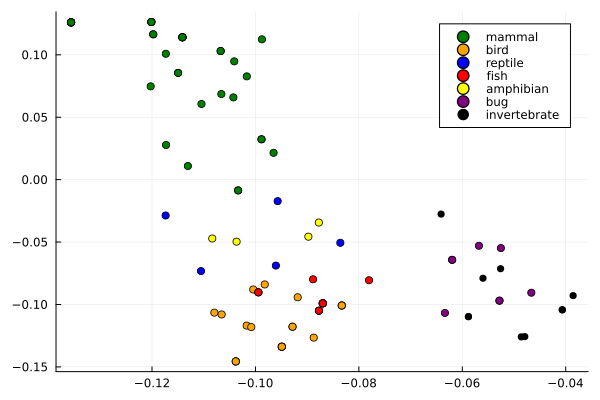

In [183]:
using Plots

function plotter()
    colors = [:green, :orange, :blue, :red, :yellow, :purple, :black]
    labels = ["mammal", "bird", "reptile", "fish", "amphibian", "bug", "invertebrate"]
    fig = Plots.plot()

    for i in 1:7
        scatter!(fig, projS[indices[i], 1], projS[indices[i], 2], mc = colors[i], label=labels[i])
    end
    return fig
end

plotter()


Produces again almost the same plot.